<a href="https://colab.research.google.com/github/Erifai/Bi_Project/blob/main/Projet_BI_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Préparation de l'environnement :**

In [1]:
#!pip install -U spacy 
#!pip install spacy-transformers
#!pip install spacy_entity_linker
#!python3 -m spacy_entity_linker "download_knowledge_base"
#!python -m spacy download en_core_web_sm
#!pip install -U sentence-transformers
#!sudo apt-get install metis

#à executer une seule fois et de redémarrer le runtime avec GPU 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **PARTIE 1 :**

In [3]:
#df = pd.read_fwf('/content/DBLP_Subset.txt')
#df=pd.read_table('/content/DBLP_Subset.txt',header=None)
#df = pd.read_csv("/content/DBLP_Subset.txt",sep="\n")
reading_file = open("/content/DBLP_Subset.txt", "r")

new_file_content = ""
count = 0
count_auth = 0
for line in reading_file:

  stripped_line = line.strip()

  new_line = stripped_line.replace(';',',')
  if "#t" in new_line :
    count_auth = 0
  if "#!" in new_line :
    count=0
  if "#@" in new_line :
    count_auth = 1
  new_line = new_line.replace('#c',';').replace('#*','\n;').replace('#c',';').replace('#t',';').replace('#index',';').replace('#!',';').replace('#@',';')
  if "#%" in new_line and count==0 :
    #print(new_line)
    new_line = new_line.replace('#%',';')
    #print(new_line)

    count =1
  if count_auth == 1 :
    new_line = new_line + ","   

  new_file_content += new_line


reading_file.close()
df = pd.DataFrame([x.split(';') for x in new_file_content.split('\n')])
# .replace('#c',';').replace('#*',';').replace('#c%',';').replace('#t',';').replace('#index',';').replace('#!',';')
#   df = pd.DataFrame([x.split(';') for x in lines.split('\n')])

In [4]:
df.rename(columns={0:"supprimer",1:"Titre",2:"Auteurs",3:"Année",4:"Revue",5:"IndexId",6:"IdRefrences",7:"Abstract"},inplace= True)
df.drop(columns=['supprimer'],inplace= True)
df.dropna(inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17852 entries, 1 to 37963
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Titre        17852 non-null  object
 1   Auteurs      17852 non-null  object
 2   Année        17852 non-null  object
 3   Revue        17852 non-null  object
 4   IndexId      17852 non-null  object
 5   IdRefrences  17852 non-null  object
 6   Abstract     17852 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [5]:
li = df['Revue'].value_counts()


In [6]:
list_revue = []
for i in range(0,len(li)-1):
  if(li[i] >= 50):
    list_revue.append(li.index[i])
  else:
    break


In [7]:
df_revue = pd.DataFrame(list_revue)
dff= pd.merge(df,df_revue,how='inner',left_on=['Revue'],right_on=[0])
dff.drop(columns=[0],inplace=True)
df = dff
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17429 entries, 0 to 17428
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Titre        17429 non-null  object
 1   Auteurs      17429 non-null  object
 2   Année        17429 non-null  object
 3   Revue        17429 non-null  object
 4   IndexId      17429 non-null  object
 5   IdRefrences  17429 non-null  object
 6   Abstract     17429 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [8]:
df['Revue'].value_counts()

DAC                                  2010
IJCAI                                1891
Electr. Notes Theor. Comput. Sci.    1891
ICCAD                                1666
SIGMOD Conference                    1529
GECCO                                1472
Discrete Applied Mathematics         1328
Journal of Systems and Software       899
ICIP                                  812
Des. Codes Cryptography               648
ICC                                   587
SIGMOD Record                         510
SMC                                   325
GECCO (Companion)                     269
Distributed Computing                 214
DATA BASE                             204
Data Min. Knowl. Discov.              175
ICCSA (1)                             152
ICCSA (2)                             145
ICCSA (3)                             144
IJCAI (1)                              82
ICCV                                   76
STOC                                   72
ICCBR                             

# PARTIE 2 :

les auteurs les plus productifs :

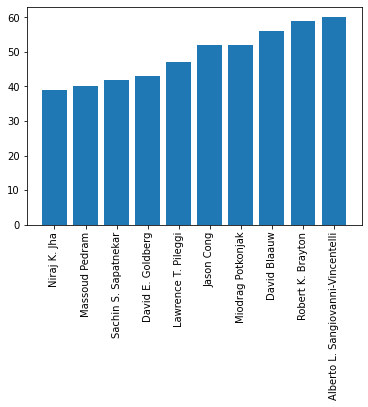

In [9]:
dict_authers = {}
def auth(x):
  li = x.split(",")
  for auth in li:
    if auth in dict_authers.keys():
      dict_authers.update({auth : dict_authers[auth] + 1})
    else:
      dict_authers[auth] = 1

df['Auteurs'].map(lambda x : auth(x))
dict_authers.pop('')
dict_auth_ord = dict(sorted(dict_authers.items(), key=lambda item: item[1]))

height = list(dict_auth_ord.keys())
height = height[-10:]
bars = list(dict_auth_ord.values())
bars = bars[-10:]
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

les articles les plus populaires :

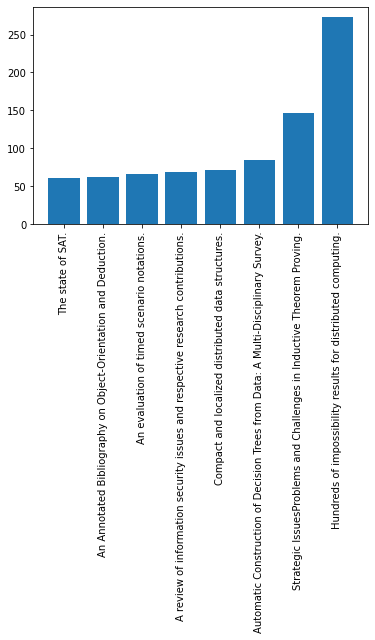

In [10]:
df['nombre_citation'] = df['IdRefrences'].map(lambda x : len(x.split("#")))

lii = df['nombre_citation'].to_list()
lii.sort()
list_nb_citation = lii[-8:]

list_abs = []
for i in list_nb_citation:
  ind = df[df['nombre_citation'] == i].index
  list_abs.append(df.at[ind[0],"Titre"])

height = list_abs
bars = list_nb_citation
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()


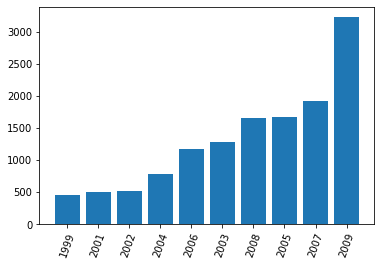

In [11]:
dff = df.groupby(['Année'])['Année'].count()
dff = dff.sort_values()
list_ind_annee = dff[-10:]
list_annee = []
for i in list_ind_annee:
  list_annee.append(dff[dff == i].index[0])

list_annee

height = list_annee
bars = list_ind_annee
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 70
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

 Distribution du nombre d’articles par revue/conférence :

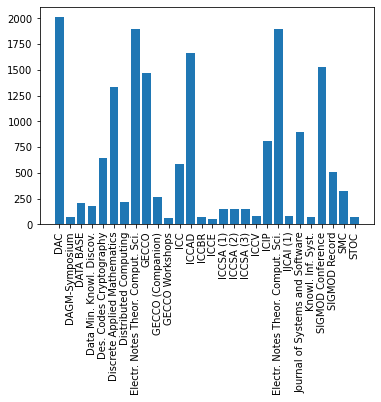

In [12]:
dff = df.groupby(['Revue'])['Année'].count()

list_revue = []
for i in dff:
  list_revue.append(dff[dff == i].index[0])

list_revue

height = list_revue
bars = dff
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

Distribution du nombre de citations :

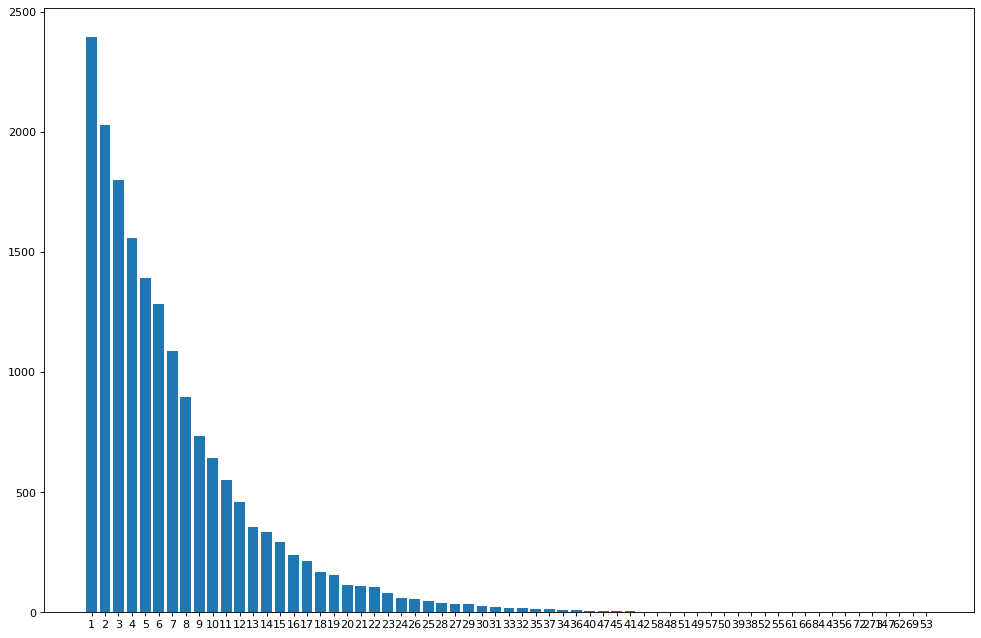

In [13]:
li = df['nombre_citation'].value_counts()

from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
height = list(li.keys())
bars = li
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 0
plt.xticks(y_pos, height,rotation = degrees)
# Show graphic
plt.show()



In [14]:
#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  lemmatizer = WordNetLemmatizer()
  string = ' '.join([lemmatizer.lemmatize(word) for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()

  return string
  


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
abstract = df.Abstract.to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]
len(abstracts_cleaned)

17429

In [16]:
from collections import Counter
cnt = Counter()
for text in abstracts_cleaned:
    for word in text.split():
        cnt[word] += 1


In [17]:
cnt.most_common(30)

[('algorithm', 11380),
 ('system', 11285),
 ('problem', 9950),
 ('model', 8898),
 ('paper', 8652),
 ('data', 8258),
 ('result', 8024),
 ('method', 7353),
 ('approach', 7060),
 ('based', 5961),
 ('design', 5933),
 ('present', 5678),
 ('set', 5437),
 ('technique', 5349),
 ('new', 5298),
 ('time', 4830),
 ('proposed', 4766),
 ('performance', 4700),
 ('application', 4285),
 ('number', 4212),
 ('network', 4175),
 ('graph', 4060),
 ('query', 3793),
 ('use', 3740),
 ('information', 3687),
 ('process', 3460),
 ('analysis', 3433),
 ('function', 3336),
 ('solution', 3295),
 ('circuit', 3218)]

# **PARTIE 3 :**

# **Transformation de données :**

In [21]:
from random import sample
df = df.sample(frac=0.5)

abstract = df.Abstract.to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]

8714

## **Exctraction de "Linked entities" :**

In [22]:
import spacy
import en_core_web_sm
from functools import reduce
nlp = spacy.load('en_core_web_sm')
# add pipeline (declared through entry_points in setup.py)
nlp.add_pipe("entityLinker",last=True)

In [23]:
listEntity =[]
dict_entities ={}
for a,abs in enumerate(abstracts_cleaned):
  doc = nlp(str(abs))
  listInter=[]
  #return all the entities in the whole document
  all_linked_entities = doc._.linkedEntities
  #itereate over sentences and print linked entities
  for sent in doc.sents:
    #print(sent._.linkedEntities)
    for i in range(len(sent._.linkedEntities)):
      entity = sent._.linkedEntities[i].get_id()
      dict_entities[sent._.linkedEntities[i].get_id()]= sent._.linkedEntities[i].get_label()
      listInter.append(entity)
  listEntity.append(listInter)


In [24]:
listEntityAll = reduce(operator.concat,listEntity)
print("listEntityAll" , len(listEntityAll))
listEntityAllunique = np.unique(np.asarray(listEntityAll))
print("listEntityAllunique" , len(listEntityAllunique))


listEntityAll 143654
listEntityAllunique 8682


## **Vectorisation (Document - mot) :**

In [25]:
vectorizer = CountVectorizer()
DocTerm_abstract = vectorizer.fit_transform(abstracts_cleaned)
print('type of DocTerm_abstract : ', type(DocTerm_abstract))
print("Documents / Mots  : ",DocTerm_abstract.shape)
print(DocTerm_abstract)

DocTerm_abstract = DocTerm_abstract.toarray()
print("******************************************")
print('DocTerm_abstract', type(DocTerm_abstract))


type of DocTerm_abstract :  <class 'scipy.sparse.csr.csr_matrix'>
Documents / Mots  :  (8714, 52010)
  (0, 7393)	6
  (0, 44752)	1
  (0, 7642)	1
  (0, 20661)	1
  (0, 45394)	4
  (0, 21451)	1
  (0, 9514)	1
  (0, 329)	1
  (0, 33495)	1
  (0, 18420)	1
  (0, 46915)	1
  (0, 21234)	1
  (0, 31435)	7
  (0, 2500)	5
  (0, 21372)	1
  (0, 36943)	1
  (0, 14845)	2
  (0, 11217)	3
  (0, 42988)	1
  (0, 15424)	1
  (0, 26626)	1
  (0, 27301)	2
  (0, 28129)	5
  (0, 35746)	2
  (0, 13850)	1
  :	:
  (8713, 2258)	1
  (8713, 49675)	1
  (8713, 18784)	2
  (8713, 41978)	1
  (8713, 11494)	1
  (8713, 22175)	1
  (8713, 5376)	1
  (8713, 48137)	1
  (8713, 13309)	2
  (8713, 50061)	2
  (8713, 12250)	1
  (8713, 14502)	1
  (8713, 10800)	2
  (8713, 2973)	3
  (8713, 50790)	1
  (8713, 14996)	1
  (8713, 50787)	2
  (8713, 27757)	1
  (8713, 41524)	1
  (8713, 5326)	1
  (8713, 26660)	1
  (8713, 21722)	1
  (8713, 43621)	1
  (8713, 22904)	2
  (8713, 22903)	2
******************************************
DocTerm_abstract <class 'numpy.ndar

## **K-means clustering (Document - mot) :**

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import pandas as pd
K=28

In [27]:
labels_all, u  = pd.factorize(df['Revue'])
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(DocTerm_abstract)
y_pred1 = kmeans.labels_
print('Bow representation clustering  accuracy : ',accuracy_score(labels_all,y_pred1))

Bow representation clustering  accuracy :  0.07229745237548772


### **Les termes les plus fréquents pour chaque cluster :**

In [28]:
word_plus_frequent_dans_chaque_cluster= []
for i in range(0,27):
  indexes = np.where(kmeans.labels_== i)
  word_plus_frequent_dans_chaque_cluster.append(vectorizer.get_feature_names()[np.argmax(np.sum(DocTerm_abstract[indexes], axis=0))])

cmp=1
for i in word_plus_frequent_dans_chaque_cluster:
  print("cluster N°  : " , cmp , " Entité la plus fréquente :" ,i)
  cmp=cmp+1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


cluster N°  :  1  Entité la plus fréquente : power
cluster N°  :  2  Entité la plus fréquente : test
cluster N°  :  3  Entité la plus fréquente : design
cluster N°  :  4  Entité la plus fréquente : problem
cluster N°  :  5  Entité la plus fréquente : technology
cluster N°  :  6  Entité la plus fréquente : algorithm
cluster N°  :  7  Entité la plus fréquente : model
cluster N°  :  8  Entité la plus fréquente : network
cluster N°  :  9  Entité la plus fréquente : quantum
cluster N°  :  10  Entité la plus fréquente : paper
cluster N°  :  11  Entité la plus fréquente : algorithm
cluster N°  :  12  Entité la plus fréquente : point
cluster N°  :  13  Entité la plus fréquente : system
cluster N°  :  14  Entité la plus fréquente : view
cluster N°  :  15  Entité la plus fréquente : information
cluster N°  :  16  Entité la plus fréquente : graph
cluster N°  :  17  Entité la plus fréquente : algorithm
cluster N°  :  18  Entité la plus fréquente : reduction
cluster N°  :  19  Entité la plus fréque

### **Évolution des clusters selon le temps (les années) :**

In [55]:
df['pred'] = kmeans.labels_
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']== li.index(chaqueU)]
  dff = z.groupby(['Année'])['Revue'].count()
  evol_clusters.append(dff)
  print("-----------------------")
  print("Cluster : ",chaqueU)
  for i in range(len(dff)):
    print(dff.index[i], dff[i])


-----------------------
Cluster :  ICCAD
1992 1
1994 3
1995 4
1996 2
1997 2
1998 3
1999 9
2000 9
2001 4
2002 13
2003 8
2004 13
2005 16
2006 12
2007 12
2008 10
2009 17
2010 1
-----------------------
Cluster :  IJCAI
1985 1
1986 1
1987 1
1989 5
1990 2
1992 7
1994 3
1995 3
1996 7
1997 6
1998 1
1999 2
2000 5
2001 7
2002 4
2003 6
2004 5
2005 7
2006 12
2007 11
2008 13
2009 9
2010 1
-----------------------
Cluster :  DAC
1971 1
1978 1
1980 1
1983 1
1985 4
1986 7
1987 4
1988 2
1989 4
1990 4
1992 4
1993 2
1994 6
1995 4
1996 4
1997 8
1998 12
1999 12
2000 10
2001 14
2002 19
2003 25
2004 18
2005 30
2006 29
2007 33
2008 31
2009 21
2010 2
-----------------------
Cluster :  ICCSA (1)
1969 3
1971 1
1973 1
1975 1
1977 3
1978 1
1981 2
1982 1
1983 4
1985 2
1987 6
1988 4
1989 8
1990 1
1991 3
1992 3
1993 9
1994 5
1995 17
1996 4
1997 6
1999 18
2000 3
2001 10
2002 12
2003 44
2004 20
2005 53
2006 23
2007 60
2008 43
2009 77
2010 4
-----------------------
Cluster :  Data Min. Knowl. Discov.
2007 4
2009 1
------

### **Nombre de citations des articles contenus dans chaque cluster :**

In [64]:
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']==li.index(chaqueU)]
  dff = z['nombre_citation'].sum()
  print("-----------------------")
  print("Nombre des citations dans le cluster : ",chaqueU)
  print( dff ,"Citations")

df.drop(columns=['pred'],inplace= True)

-----------------------
Nombre des citations dans le cluster :  ICCAD
1052 Citations
-----------------------
Nombre des citations dans le cluster :  IJCAI
866 Citations
-----------------------
Nombre des citations dans le cluster :  DAC
2191 Citations
-----------------------
Nombre des citations dans le cluster :  ICCSA (1)
2965 Citations
-----------------------
Nombre des citations dans le cluster :  Data Min. Knowl. Discov.
44 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO (Companion)
94 Citations
-----------------------
Nombre des citations dans le cluster :  Electr. Notes Theor. Comput. Sci.
3457 Citations
-----------------------
Nombre des citations dans le cluster :  DATA BASE
1761 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO
72 Citations
-----------------------
Nombre des citations dans le cluster :  Discrete Applied Mathematics
20394 Citations
-----------------------
Nombre des citations dans le cluster :  Des.

### **Sphérical K-means :**

In [65]:
from nltk.cluster import KMeansClusterer
kclusterer = KMeansClusterer(K, distance=nltk.cluster.util.cosine_distance)
ypredspher = kclusterer.cluster(DocTerm_abstract,True)

print('Spherical K-means clustering (Matrix document - mot ) accuracy : ',accuracy_score(labels_all,ypredspher))

KeyboardInterrupt: ignored

### **Les termes les plus fréquents pour chaque cluster (Spherical Kmeans) :**

In [ ]:
word_plus_frequent_dans_chaque_cluster= []
for i in range(0,27):
  indexes = np.where(ypredspher == i)
  word_plus_frequent_dans_chaque_cluster.append(vectorizer.get_feature_names()[np.argmax(np.sum(DocTerm_abstract[indexes], axis=0))])

cmp=1
for i in word_plus_frequent_dans_chaque_cluster:
  print("cluster N°  : " , cmp , " Entité la plus fréquente :" ,i)
  cmp=cmp+1

### **Évolution des clusters selon le temps (les années) (Spherical Kmeans) :**

In [ ]:
df['pred'] = ypredspher
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']== li.index(chaqueU)]
  dff = z.groupby(['Année'])['Revue'].count()
  evol_clusters.append(dff)
  print("-----------------------")
  print("Cluster : ",chaqueU)
  for i in range(len(dff)):
    print(dff.index[i], dff[i])

-----------------------
Cluster :  ICCAD
1992 41
1993 3
1994 49
1995 46
1996 51
1997 48
1998 1
1999 57
2000 46
2001 53
2002 55
2003 72
2004 46
2005 69
2006 74
2007 65
2008 57
-----------------------
Cluster :  IJCAI
1969 12
1971 9
1973 11
1975 27
1977 25
1981 37
1983 34
1985 43
1987 64
1989 82
1991 66
1993 53
1995 80
1997 18
1999 69
2001 78
2003 92
2005 113
2007 36
-----------------------
Cluster :  DAC
1985 24
1986 30
1987 30
1988 35
1989 49
1990 42
1992 12
1993 3
1994 1
1995 1
1996 3
1997 52
1998 46
1999 33
2000 39
2001 44
2002 65
2003 76
2004 83
2005 63
2006 85
2007 91
2008 86
2009 50
-----------------------
Cluster :  ICCSA (1)
2003 28
2007 49
2008 5
-----------------------
Cluster :  Data Min. Knowl. Discov.
1997 3
1998 5
1999 7
2000 6
2001 8
2002 5
2003 4
2004 8
2005 5
2006 8
2007 9
2008 6
2009 10
2010 4
-----------------------
Cluster :  GECCO (Companion)
2007 38
2008 30
2009 58
-----------------------
Cluster :  Electr. Notes Theor. Comput. Sci.
1996 2
1998 1
1999 2
2000 1
2001

### **Nombre de citations des articles contenus dans chaque cluster  (Spherical K-means) :**

In [ ]:
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']==li.index(chaqueU)]
  dff = z['nombre_citation'].sum()
  print("-----------------------")
  print("Nombre des citations dans le cluster : ",chaqueU)
  print( dff ,"Citations")

df.drop(columns=['pred'],inplace= True)

-----------------------
Nombre des citations dans le cluster :  ICCAD
6129 Citations
-----------------------
Nombre des citations dans le cluster :  IJCAI
4134 Citations
-----------------------
Nombre des citations dans le cluster :  DAC
6319 Citations
-----------------------
Nombre des citations dans le cluster :  ICCSA (1)
343 Citations
-----------------------
Nombre des citations dans le cluster :  Data Min. Knowl. Discov.
1278 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO (Companion)
602 Citations
-----------------------
Nombre des citations dans le cluster :  Electr. Notes Theor. Comput. Sci.
7465 Citations
-----------------------
Nombre des citations dans le cluster :  DATA BASE
667 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO
3199 Citations
-----------------------
Nombre des citations dans le cluster :  Discrete Applied Mathematics
4259 Citations
-----------------------
Nombre des citations dans le cluster :  D

In [68]:
del(DocTerm_abstract)

NameError: ignored

## **Document - Entité**

In [67]:
dictindex = dict(zip(listEntityAllunique,np.arange(len(listEntityAllunique))))
entityEmbedding = np.zeros((len(abstract),len(listEntityAllunique)))
for a in range(0,len(abstract)):
  lista = listEntity[a]
  indexEn = np.asanyarray(list(map(dictindex.get,lista)))
  if len(indexEn) > 0 : 
    entityEmbedding[a,indexEn]=1

## **K-means clustering (Document - Entité) :**

In [69]:
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(entityEmbedding)
print('Entity  representation clustering  accuracy : ',accuracy_score(labels_all,kmeans.labels_))

Entity  representation clustering  accuracy :  0.02364011934817535


### **Les entités les plus fréquentes pour chaque cluster :**

In [70]:
entity_plus_frequent_dans_chaque_cluster=[]
for i in range(0,27):
  indexes = np.where(kmeans.labels_== i)
  entity_plus_frequent_dans_chaque_cluster.append(listEntityAllunique[np.argmax(np.sum(entityEmbedding[indexes], axis=0))])

cmp=1
for i in entity_plus_frequent_dans_chaque_cluster:
  print("cluster N°  : " , cmp , " l'entité la plus fréquente :" ,dict_entities[i])
  cmp=cmp+1



cluster N°  :  1  l'entité la plus fréquente : technology
cluster N°  :  2  l'entité la plus fréquente : process
cluster N°  :  3  l'entité la plus fréquente : algorithm
cluster N°  :  4  l'entité la plus fréquente : Egypt
cluster N°  :  5  l'entité la plus fréquente : data
cluster N°  :  6  l'entité la plus fréquente : performance
cluster N°  :  7  l'entité la plus fréquente : Planck constant
cluster N°  :  8  l'entité la plus fréquente : system
cluster N°  :  9  l'entité la plus fréquente : paper
cluster N°  :  10  l'entité la plus fréquente : language
cluster N°  :  11  l'entité la plus fréquente : design
cluster N°  :  12  l'entité la plus fréquente : algorithm
cluster N°  :  13  l'entité la plus fréquente : algebra
cluster N°  :  14  l'entité la plus fréquente : electrical network
cluster N°  :  15  l'entité la plus fréquente : result
cluster N°  :  16  l'entité la plus fréquente : mathematical model
cluster N°  :  17  l'entité la plus fréquente : paper
cluster N°  :  18  l'entité

### **Évolution des clusters selon le temps (les années) :**

In [71]:
df['pred'] = kmeans.labels_
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']== li.index(chaqueU)]
  dff = z.groupby(['Année'])['Revue'].count()
  evol_clusters.append(dff)
  print("-----------------------")
  print("Cluster : ",chaqueU)
  for i in range(len(dff)):
    print(dff.index[i], dff[i])


-----------------------
Cluster :  ICCAD
2009 1
-----------------------
Cluster :  IJCAI
1973 1
1975 3
1977 3
1981 2
1982 1
1983 2
1985 3
1987 7
1988 2
1989 7
1990 2
1991 2
1992 2
1993 4
1995 4
1996 1
1997 4
1998 3
1999 8
2000 4
2001 5
2002 8
2003 19
2004 12
2005 33
2006 18
2007 36
2008 41
2009 44
2010 7
-----------------------
Cluster :  DAC
1975 1
1983 2
1986 1
1987 6
1988 3
1989 4
1991 3
1992 2
1993 4
1994 1
1995 7
1996 3
1997 6
1998 5
1999 13
2000 13
2001 12
2002 9
2003 23
2004 17
2005 28
2006 18
2007 39
2008 29
2009 56
2010 6
-----------------------
Cluster :  ICCSA (1)
2003 1
-----------------------
Cluster :  Data Min. Knowl. Discov.
1969 1
1971 1
1973 2
1975 8
1976 4
1977 3
1978 2
1979 3
1981 7
1982 3
1983 8
1984 2
1985 2
1986 3
1987 11
1988 5
1989 7
1990 6
1991 5
1992 5
1993 9
1994 5
1995 7
1996 12
1997 17
1998 12
1999 13
2000 18
2001 19
2002 27
2003 37
2004 27
2005 44
2006 34
2007 43
2008 40
2009 103
2010 32
-----------------------
Cluster :  GECCO (Companion)
1977 2
1979 1
1

### **Nombre de citations des articles contenus dans chaque cluster  (Spherical K-means) :**

In [72]:
labels_all, u  = pd.factorize(df['Revue'])
evol_clusters=[]
li = list(u)
for chaqueU in u:  
  z = df[df['pred']==li.index(chaqueU)]
  dff = z['nombre_citation'].sum()
  print("-----------------------")
  print("Nombre des citations dans le cluster : ",chaqueU)
  print( dff ,"Citations")

df.drop(columns=['pred'],inplace= True)

-----------------------
Nombre des citations dans le cluster :  ICCAD
1 Citations
-----------------------
Nombre des citations dans le cluster :  IJCAI
2249 Citations
-----------------------
Nombre des citations dans le cluster :  DAC
3025 Citations
-----------------------
Nombre des citations dans le cluster :  ICCSA (1)
3 Citations
-----------------------
Nombre des citations dans le cluster :  Data Min. Knowl. Discov.
5553 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO (Companion)
3664 Citations
-----------------------
Nombre des citations dans le cluster :  Electr. Notes Theor. Comput. Sci.
7 Citations
-----------------------
Nombre des citations dans le cluster :  DATA BASE
4857 Citations
-----------------------
Nombre des citations dans le cluster :  GECCO
4668 Citations
-----------------------
Nombre des citations dans le cluster :  Discrete Applied Mathematics
2 Citations
-----------------------
Nombre des citations dans le cluster :  Des. Codes

# **Clustering**

In [ ]:
from nltk.cluster import KMeansClusterer
kclusterer = KMeansClusterer(K, distance=nltk.cluster.util.cosine_distance)
ypredspher = kclusterer.cluster(entityEmbedding,True)

print('Entity  representation clustering  accuracy : ',accuracy_score(labels_all,ypredspher))

/usr/local/lib/python3.7/dist-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
print(ypredspher)
print('Entity  representation clustering  accuracy : ',accuracy_score(labels_all,ypredspher))

[3, 26, 17, 27, 23, 4, 22, 21, 11, 2, 26, 15, 25, 3, 4, 17, 4, 1, 26, 21, 7, 25, 22, 14, 26, 15, 0, 17, 27, 19, 14, 2, 24, 27, 10, 2, 9, 4, 3, 26, 2, 24, 8, 7, 19, 25, 11, 23, 13, 17, 15, 7, 19, 15, 5, 8, 17, 4, 15, 11, 5, 3, 8, 0, 7, 17, 21, 2, 4, 23, 17, 12, 3, 10, 1, 18, 22, 26, 6, 3, 4, 6, 12, 11, 22, 1, 8, 23, 21, 14, 8, 22, 24, 20, 26, 0, 25, 25, 6, 25, 12, 11, 26, 22, 23, 20, 24, 2, 22, 7, 2, 0, 1, 3, 19, 8, 22, 3, 7, 13, 25, 0, 23, 3, 3, 27, 7, 13, 15, 6, 23, 11, 26, 24, 20, 11, 20, 22, 24, 21, 24, 20, 3, 25, 0, 10, 27, 26, 3, 11, 4, 10, 9, 18, 11, 26, 26, 2, 13, 22, 18, 23, 24, 11, 12, 2, 19, 5, 26, 26, 12, 12, 26, 3, 26, 18, 6, 0, 22, 12, 14, 27, 13, 5, 3, 18, 23, 3, 27, 27, 16, 23, 8, 0, 0, 21, 6, 12, 14, 23, 26, 21, 7, 22, 19, 8, 23, 5, 26, 3, 3, 2, 10, 12, 22, 24, 5, 26, 22, 14, 7, 2, 25, 24, 3, 23, 2, 24, 2, 6, 11, 9, 9, 3, 8, 21, 24, 20, 5, 11, 3, 9, 22, 24, 14, 9, 2, 0, 22, 4, 14, 3, 24, 22, 23, 8, 0, 6, 2, 3, 25, 12, 7, 14, 4, 0, 19, 8, 7, 6, 19, 9, 20, 9, 24, 22, 9, 9

In [ ]:
ypredspher = np.array(result)
ypredspher
#kmeans.labels_

array([ 3, 26, 17, ..., 12, 25, 11])